The goal of this notebook is to train a model to detect whether an image is eczema or not. For this model, the model will only be trained on skin without eczema images and skin with eczema images.

## Gather Training data

In [1]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [7]:
urls = search_images('skin with Eczema photos', max_images=1)
urls[0]

'http://2.bp.blogspot.com/-t27DoRKxqYM/UoyKLNsVuEI/AAAAAAAAxtw/IgxAbtwYVGE/s1600/Eczema+Skin+Causes,+Symptoms,+Types,+Diagnosis,+Treatments++(6).jpg'

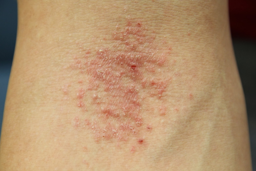

In [8]:
from fastdownload import download_url
dest = 'eczema.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256) # preview exczema image

/home/bobby/.local/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/home/bobby/.local/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/home/bobby/.local/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


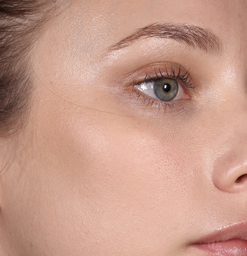

In [5]:
download_url(search_images('normal skin photos', max_images=1)[0], 'normal_skin.jpg', show_progress=False)
Image.open('normal_skin.jpg').to_thumb(256,256) # preview normmal skin image

Search and save more examples of "Eczema" and "Normal Skin":

In [10]:
searches = 'eczema','normal skin'
path = Path('eczema_or_not')
from time import sleep

# for o in searches:
#     dest = (path/o)
#     dest.mkdir(exist_ok=True, parents=True)
#     download_images(dest, urls=search_images(f'{o} photo'))
#     sleep(10)  # Pause between searches to avoid over-loading server
#     download_images(dest, urls=search_images(f'{o} hand photo'))
#     sleep(10)
#     download_images(dest, urls=search_images(f'{o} arm photo'))
#     sleep(10)
#     resize_images(path/o, max_size=400, dest=path/o)

Remove any broken images to avoid model training disruption/failure:

In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

## Training the Model

Load DataBlock which is a custom fastai object to easily create a Training and Validation dataset from the data we input:

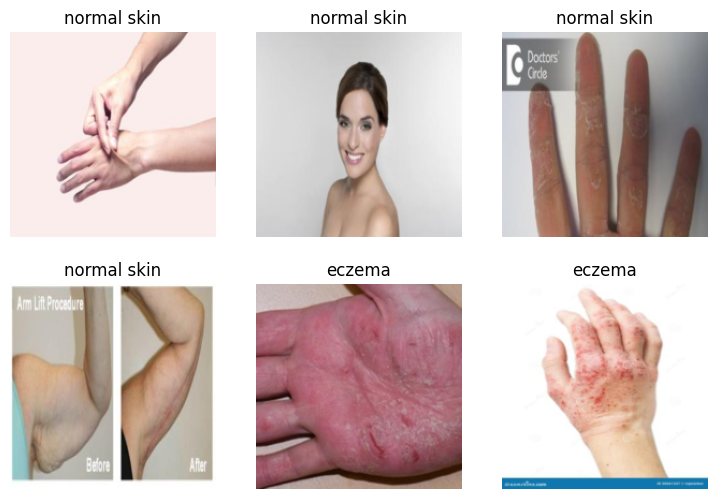

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

Checking if GPU is enabled:

In [13]:
torch.cuda.is_available()

True

Call vision_learner and include model. I chose resnet18, but could test out a larger model since I have a GPU Chose 3 epochs for training, but can increase:

In [14]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/home/bobby/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bobby/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.039863,0.863604,0.316327,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.680947,0.648722,0.244898,00:02
1,0.487019,0.802536,0.255102,00:02
2,0.354019,0.825100,0.285714,00:02


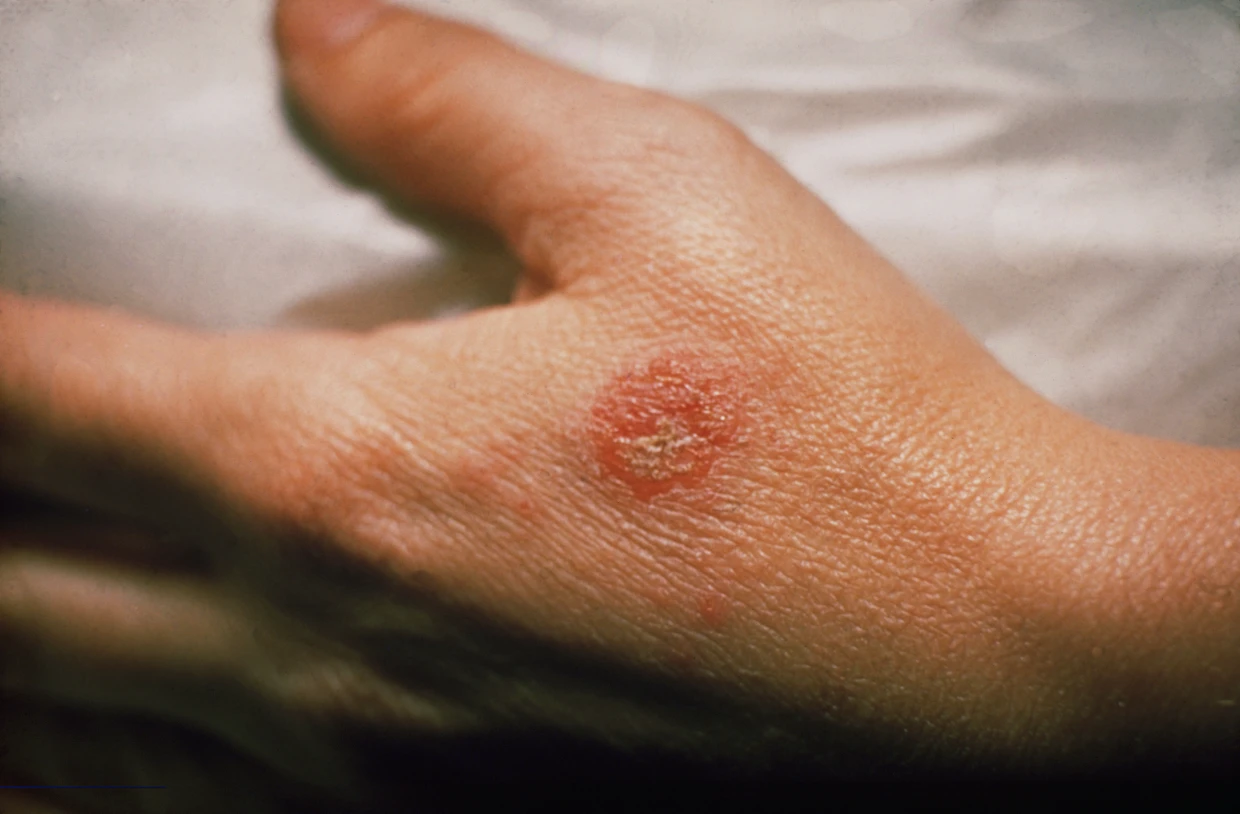

In [19]:
PILImage.create("test1.jpg")

In [16]:
is_eczema,_,probs = learn.predict("test1.jpg")
print(f"This is a: {is_eczema}.")
print(f"Probability it's a eczema: {probs[0]:.4f}")

This is a: eczema.
Probability it's a eczema: 0.9778
